In [30]:

import math
import os
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from dotenv import load_dotenv
from google.cloud import bigquery
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, RobustScaler, StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, LSTM, LeakyReLU
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import wes
from matplotlib.colors import LinearSegmentedColormap
load_dotenv()


True

In [31]:

google_credentials = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
PROJECT = "focus-hulling-416322"
DATASET = "2016"
TABLE = "out_and_in_2016_v4"

# Ensure the project, dataset, and table names are correctly formatted
# using backticks to avoid syntax errors
query = f"""
    SELECT *
    FROM `{PROJECT}.{DATASET}.{TABLE}`
"""

client = bigquery.Client(project=PROJECT)
query_job = client.query(query)
result = query_job.result()
data = result.to_dataframe()


In [23]:
# Cleaning the column names
df = data.clean_names()

# Changin the values inside the clinic column for onehot encoding
value_map = {1: 'Inpatient', 2: 'Outpatient'}
df['clinic'] = df['clinic'].map(value_map)

#Chaning the values for region_mod
value_map_2 = {'1': 'northeast', '2':'northcentral', '3':'south', '4':'west', '5':'unknown'}
df['region_mod'] = df['region_mod'].map(value_map_2)

#chaning the gender varible
value_map_3 = {'1':'male', '2':'female'}
df['gender'] = df['gender'].map(value_map_3)

# # Creating values for Plantype
# value_map_4 = {1: 'basic', 2: 'comprihensive', 3:'epo', 4:'hmo', 5:'pos', 6:'ppo', 7:'pos2', 8:'cdhp', 9:'hdhp'}


def encode_and_bind(original_dataframe, features_to_encode):

    # Convert a single feature name to a list
    if isinstance(features_to_encode, str):
        features_to_encode = [features_to_encode]

    # Check if the features exist in the dataframe
    for feature in features_to_encode:
        if feature not in original_dataframe.columns:
            raise ValueError(f"Feature '{feature}' not found in the dataframe")

    # One-hot encoding
    encoder = OneHotEncoder(sparse_output = False)
    encoder.fit(original_dataframe[features_to_encode])
    encoded_features = encoder.transform(original_dataframe[features_to_encode])

    # Add new encoded columns to the dataframe
    original_dataframe[encoder.get_feature_names_out(features_to_encode)] = encoded_features

    # Drop the original columns
    original_dataframe.drop(columns=features_to_encode, inplace=True)

    # Return the modified dataframe
    return original_dataframe

features_to_encode = ['clinic', 'gender']

encode_and_bind(df, features_to_encode)

value_to_encode = [183, 184, 185, 521, 522, 533, 534, 545, 536, 542, 543, 544, 562, 563]
df['trauma'] = df['drg'].apply(lambda x: 1 if x in value_to_encode else 0)
df.loc[df['drg'].between(280, 283), 'myocardial_infarction'] += 1
df = df.drop(columns=['health_plan_type','plan_typ', 'drg', 'patient_zipcode'])
# repaet clean_names()
# df = df.clean_names()

group_columns = ['patient_id', 'gender_male','relationship_to_primary_beneficiary']
agg_dict = {col: 'sum' for col in df.columns if col not in group_columns}
agg_dict['age_years'] = 'mean'
df = df.groupby(group_columns).agg(agg_dict).reset_index()

# #sorting out patient_id column
df['patient_id'] = df['patient_id'].astype(str)
df['patient_id'] = df['patient_id'].str.slice(0, -2)

# #eliminating the negative pay values
df = df[(df['age_years'] > 17) & (df['pay'].between(2,1000000))]

df = df.clean_names()
# #removing the duplicates
duplicates = df.duplicated(subset='patient_id', keep=False)
duplicate_rows= df[duplicates]
duplicate_rows.sort_values(by='patient_id')
df.drop_duplicates(inplace=True)
df['both_clinic'] = np.where((df['clinic_inpatient'] == 1.0) & (df['clinic_outpatient'] == 1.0), 1,0)


# df = df.astype(float)
columns_to_replace = [
    'myocardial_infarction', 'trauma', 'chf', 'pvd', 'cardiovascular_d'
    'respiratory_d', 'hypertension', 'diabetes_melitus', 'dementia',
    'kidney_disease', 'liver_disease', 'diarrheal_disease', 'cancer',
    'metastasis', 'puc', 'hemiplegia', 'lymphoma', 'aids',
    'connective_tissue_disease',
    # 'region_mod_northcentral',
    # 'region_mod_northeast',
    # 'region_mod_south',
    # 'region_mod_west',
    # 'region_mod_unknown',
    'clinic_outpatient', 'clinic_inpatient', 'both_clinic', 'gender_female',
    'gender_male'
]
for column in columns_to_replace:
    if column in df.columns:
        # Create a mask for values greater than zero
        mask = df[column] > 0
        # Apply the mask and set those values to 1
        df.loc[mask, column] = 1


# CCI score
df['cci'] = 0
df['cci']= pd.cut(df['age_years'],
                    bins=[0, 49, 59, 69, 79, float('inf')],
                    labels=[0, 1, 2, 3, 4],
                    right=False).astype(int)
df.loc[df['myocardial_infarction'] == 1.0, 'cci'] +=1
df.loc[df['chf'] == 1.0, 'cci'] +=1
df.loc[df['pvd'] == 1.0, 'cci'] +=1
df.loc[df['respiratory_d'] == 1.0, 'cci'] +=1
df.loc[df['connective_tissue_disease'] == 1.0, 'cci'] +=1
df.loc[df['liver_disease'] == 1.0, 'cci'] +=1
df.loc[df['diabetes_melitus'] == 1.0, 'cci'] +=1
df.loc[df['kidney_disease'] == 1.0, 'cci'] +=1
df.loc[df['puc'] == 1.0, 'cci'] +=1
df.loc[df['hemiplegia'] == 1.0, 'cci'] +=2
df.loc[df['lymphoma'] == 1.0, 'cci'] +=2
df.loc[df['aids'] == 1.0, 'cci'] +=6
df.loc[df['cancer'] == 1.0, 'cci'] +=2
df.loc[df['metastasis'] == 1.0, 'cci'] +=6

# scaling_columns = ['lohs', 'clinic_visits', 'age_years']
# def scaler_minmax(data_frame, scaling_columns):
#     minmax = MinMaxScaler()
#     if isinstance(scaling_columns, str):  # If a single column name is passed as a string
#         scaling_columns = [scaling_columns]  # Convert it to a list

#     minmax.fit(data_frame[scaling_columns])
#     data_frame[scaling_columns] = minmax.transform(data_frame[scaling_columns])
# scaler_minmax(df, scaling_columns)

## relationship to primary beneficiary is to high, the numbers have been added up
## health plan type

### outliers ###

## Preparing the X and the y

In [14]:
# Preparing the data

X = df.drop(columns=['pay', 'clinic_outpatient','patient_id','coinsurance', 'copay', 'deductable', 'net', 'region_mod_unknown'])
y = df['pay']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
init_dict = {'age_years': 0,
            'relationship_to_primary_beneficiary': 0,
            'clinic_visits': 0,
            'clinic_inpatient': 0,
            'region_mod_northcentral': 0,
            'region_mod_northeast': 0,
            'region_mod_south': 0,
            'region_mod_west': 0,
            'gender_female':0,
            'gender_male':0,
            'both_clinic':0,
            'cci': 0}
init_lst = list(init_dict.keys())

disease_name_mapping = {
        'respiratory_d': 'Respiratory Disease',
        'hypertension': 'Hypertension',
        'diabetes_melitus': 'Diabetes Melitus',
        'dementia': 'Dementia',
        'kidney_disease': 'Kidney Disease',
        'liver_disease': 'Liver Disease',
        'diarrheal_disease': 'Diarrheal Disease',
        'myocardial_infarction': 'Myocardial Infarction',
        'cardiovascular_d': 'Cardiovascular Disease',
        'chf': 'Heart Failure',
        'pvd': 'Peripherial Vascular Disease',
        'cancer': 'Non-Metastatic Cancer',
        'metastasis': 'Metastatic Cancer',
        'connective_tissue_disease': 'Autoimmune Disease',
        'puc': 'Peptic Ulcer',
        'hemiplegia': 'Stroke',
        'lymphoma': 'Lymphoma',
        'aids': 'AIDS',
        'trauma': 'Previous Fracture'
    }
init_lst.extend(list(disease_name_mapping.keys()))
column_order =init_lst

columns_to_convert = ['clinic_inpatient',
 'region_mod_northcentral',
 'region_mod_northeast',
 'region_mod_south',
 'region_mod_west',
 'gender_female',
 'gender_male',
 'both_clinic',
 'cci',
 'respiratory_d',
 'hypertension',
 'diabetes_melitus',
 'dementia',
 'kidney_disease',
 'liver_disease',
 'diarrheal_disease',
 'myocardial_infarction',
 'cardiovascular_d',
 'chf',
 'pvd',
 'cancer',
 'metastasis']  # List your columns here

for column in columns_to_convert:
    df[column] = df[column].astype(int)



X = X[column_order]
X

,age_years,relationship_to_primary_beneficiary,clinic_visits,clinic_inpatient,region_mod_northcentral,region_mod_northeast,region_mod_south,region_mod_west,gender_female,gender_male,...,chf,pvd,cancer,metastasis,connective_tissue_disease,puc,hemiplegia,lymphoma,aids,trauma
0,0.914894,2.0,0.014272,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.978723,2.0,0.001903,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.744681,3.0,0.074215,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.914894,3.0,0.059943,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.893617,2.0,0.050428,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298456,0.872340,1.0,0.006660,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2298457,0.297872,1.0,0.006660,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2298458,0.723404,2.0,0.028544,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2298459,0.382979,1.0,0.003806,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor

# Assuming df is your DataFrame and column_order is defined
X = df.drop(columns=['pay', 'clinic_outpatient', 'patient_id', 'coinsurance', 'copay', 'deductable', 'net', 'region_mod_unknown'])
X = X[column_order]
y = df['pay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe_lr = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=100,
                                                       activation='relu', solver='adam'))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.15)
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.15)

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.show()


/Users/amermujkanovic/.pyenv/versions/3.10.6/envs/RaphaelHealth/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/amermujkanovic/.pyenv/versions/3.10.6/envs/RaphaelHealth/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/amermujkanovic/.pyenv/versions/3.10.6/envs/RaphaelHealth/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/amermujkanovic/.pyenv/versions/3.10.6/envs/RaphaelHealth/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: Converg

In [ ]:
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

In [21]:
X.columns

Index(['age_years', 'relationship_to_primary_beneficiary', 'clinic_visits',
       'clinic_inpatient', 'region_mod_northcentral', 'region_mod_northeast',
       'region_mod_south', 'region_mod_west', 'gender_female', 'gender_male',
       'both_clinic', 'cci', 'respiratory_d', 'hypertension',
       'diabetes_melitus', 'dementia', 'kidney_disease', 'liver_disease',
       'diarrheal_disease', 'myocardial_infarction', 'cardiovascular_d', 'chf',
       'pvd', 'cancer', 'metastasis', 'connective_tissue_disease', 'puc',
       'hemiplegia', 'lymphoma', 'aids', 'trauma'],
      dtype='object')

# Gradient Boosting Machine

In [16]:
gbm = GradientBoostingRegressor(n_estimators=200,
                                min_samples_split=30,
                                min_samples_leaf=7,
                                max_depth=8 ,
                                learning_rate=0.01,
                                random_state=42)
gbm.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=0.01, max_depth=8, min_samples_leaf=7,
                          min_samples_split=30, n_estimators=200,
                          random_state=42)

In [ ]:
y_pred = gbm.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Abs Error: {mae}")


Mean Abs Error: 9044.253686211681


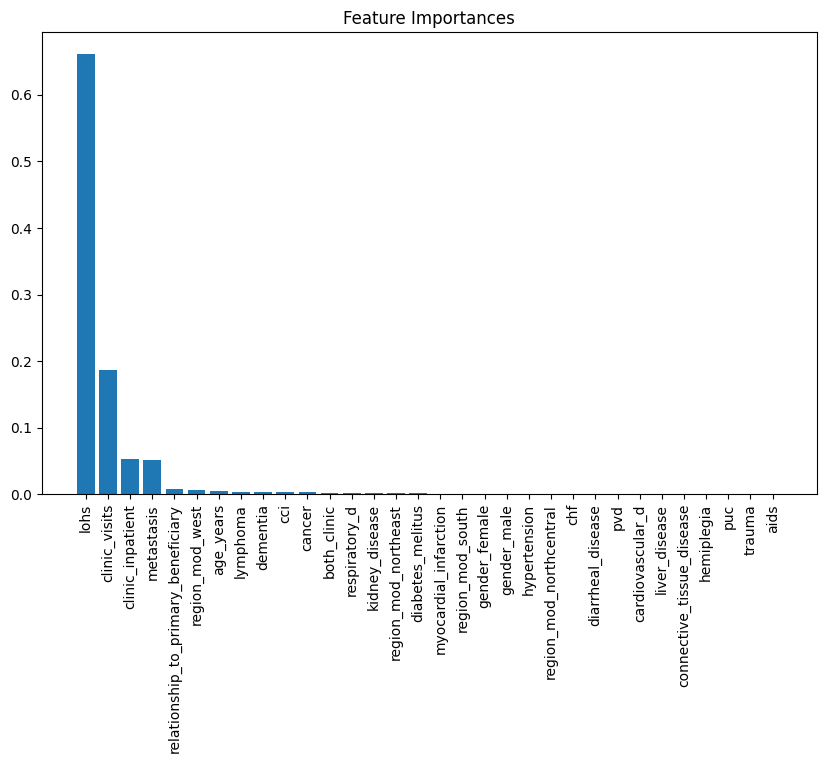

In [167]:
# Accessing feature importances
feature_importances = gbm.feature_importances_

# Match the feature names from your dataset
feature_names = X_train.columns

# Create a DataFrame for easy visualization
importances_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# Sort the DataFrame by importance
importances_df = importances_df.sort_values(by='importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(importances_df['feature'], importances_df['importance'])
plt.xticks(rotation='vertical')
plt.show()

In [17]:
from joblib import dump, load

dump(gbm, 'GradientBost_model.joblib')

['GradientBost_model.joblib']

In [18]:
model = load('GradientBost_model.joblib')

In [153]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
# Load dataset



# Split dataset into training and testing sets
model = models.Sequential()
model.add(layers.Dense(32, activation= 'relu', input_shape=(X_train.shape[1],)))
# model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dropout(0.3))
# model.add(layers.Dense(3, activation='relu',
#                        kernel_regularizer=regularizers.l1(0.01)))
# model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='linear'))


# eraly stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose =1,
                               restore_best_weights=True)


# # Compile the model
model.compile(optimizer=Adam(0.1),  # A lower learning rate
              loss='mean_absolute_error',
              metrics=['mae'])
# Train the model
model.fit(X_train, y_train, epochs=59, batch_size=32, validation_split=0.3, callbacks=[early_stopping])

# Evaluate the model on test data
results = model.evaluate(X_test, y_test)
# print(f'Test loss: {test_loss}')

/Users/amermujkanovic/.pyenv/versions/3.10.6/envs/RaphaelHealth/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/59
35575/35575 ━━━━━━━━━━━━━━━━━━━━ 16s 453us/step - loss: 183230.5000 - mae: 183230.5000 - val_loss: 8616.4844 - val_mae: 8616.7500
Epoch 2/59
35575/35575 ━━━━━━━━━━━━━━━━━━━━ 15s 433us/step - loss: 10768.0947 - mae: 10768.0947 - val_loss: 8745.6787 - val_mae: 8745.9639
Epoch 3/59
35575/35575 ━━━━━━━━━━━━━━━━━━━━ 16s 438us/step - loss: 10308.9307 - mae: 10308.9307 - val_loss: 14443.9990 - val_mae: 14444.6582
Epoch 4/59
35575/35575 ━━━━━━━━━━━━━━━━━━━━ 15s 426us/step - loss: 14444.3115 - mae: 14444.3115 - val_loss: 14306.6133 - val_mae: 14307.2676
Epoch 5/59
35575/35575 ━━━━━━━━━━━━━━━━━━━━ 15s 424us/step - loss: 14281.3877 - mae: 14281.3877 - val_loss: 14306.4961 - val_mae: 14307.1494
Epoch 6/59
35575/35575 ━━━━━━━━━━━━━━━━━━━━ 15s 411us/step - loss: 14352.1494 - mae: 14352.1494 - val_loss: 14306.4805 - val_mae: 14307.1338
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
12706/12706 ━━━━━━━━━━━━━━━━━━━━ 3s 238us/step - loss: 8624.7402 - mae: 8

In [128]:
columns_to_convert = ['clinic_inpatient',
 'region_mod_northcentral',
 'region_mod_northeast',
 'region_mod_south',
 'region_mod_west',
 'gender_female',
 'gender_male',
 'both_clinic',
 'cci',
 'respiratory_d',
 'hypertension',
 'diabetes_melitus',
 'dementia',
 'kidney_disease',
 'liver_disease',
 'diarrheal_disease',
 'myocardial_infarction',
 'cardiovascular_d',
 'chf',
 'pvd',
 'cancer',
 'metastasis']  # List your columns here

for column in columns_to_convert:
    df[column] = df[column].astype(int)

(1626256, 32)

In [19]:
import pickle

# Assuming `model` is your trained machine learning model
with open('model.pkl', 'wb') as file:
    pickle.dump(gbm, file)

In [6]:
model

GradientBoostingRegressor(learning_rate=0.01, max_depth=8, min_samples_leaf=7,
                          min_samples_split=30, n_estimators=200,
                          random_state=42)

/var/folders/fh/fc20820s23gdqf7bkj31z2rw0000gn/T/ipykernel_37508/971354160.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_years', y='pay', data=df, palette=wes_palette)
/var/folders/fh/fc20820s23gdqf7bkj31z2rw0000gn/T/ipykernel_37508/971354160.py:5: UserWarning: 
The palette list has fewer values (4) than needed (48) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='age_years', y='pay', data=df, palette=wes_palette)


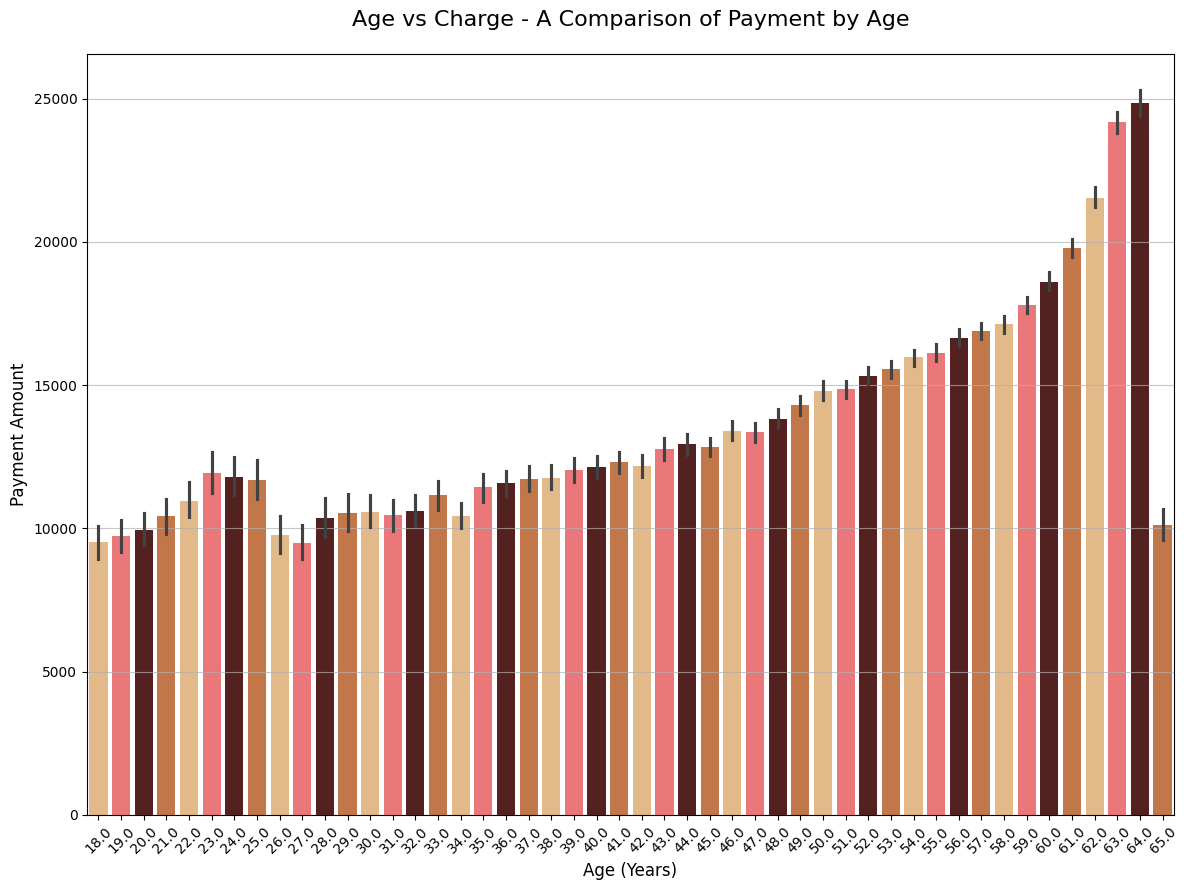

In [19]:
wes_palette = ["#F1BB7B", "#FD6467", "#5B1A18", "#D67236"]  # Replace with your chosen colors

plt.figure(figsize=(12, 9))
plt.title('Age vs Charge - A Comparison of Payment by Age', fontsize=16, pad=20)
sns.barplot(x='age_years', y='pay', data=df, palette=wes_palette)
plt.xlabel('Age (Years)', fontsize=12)
plt.ylabel('Payment Amount', fontsize=12)
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.grid(axis='y', linestyle='-', alpha=0.7)

plt.tight_layout()

In [ ]:
wes_palette = ["#F1BB7B", "#FD6467", "#5B1A18", "#D67236"]  # Replace with your chosen colors

plt.figure(figsize=(12, 9))
plt.title('Age vs Charge - A Comparison of Payment by Age', fontsize=16, pad=20)
sns.barplot(x='age_years', y='pay', data=df, palette=wes_palette)
plt.xlabel('Age (Years)', fontsize=12)
plt.ylabel('Payment Amount', fontsize=12)
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.grid(axis='y', linestyle='-', alpha=0.7)

plt.tight_layout()

/var/folders/fh/fc20820s23gdqf7bkj31z2rw0000gn/T/ipykernel_37508/3147507298.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='region_mod', y='pay', data=df, palette=wes_palette)


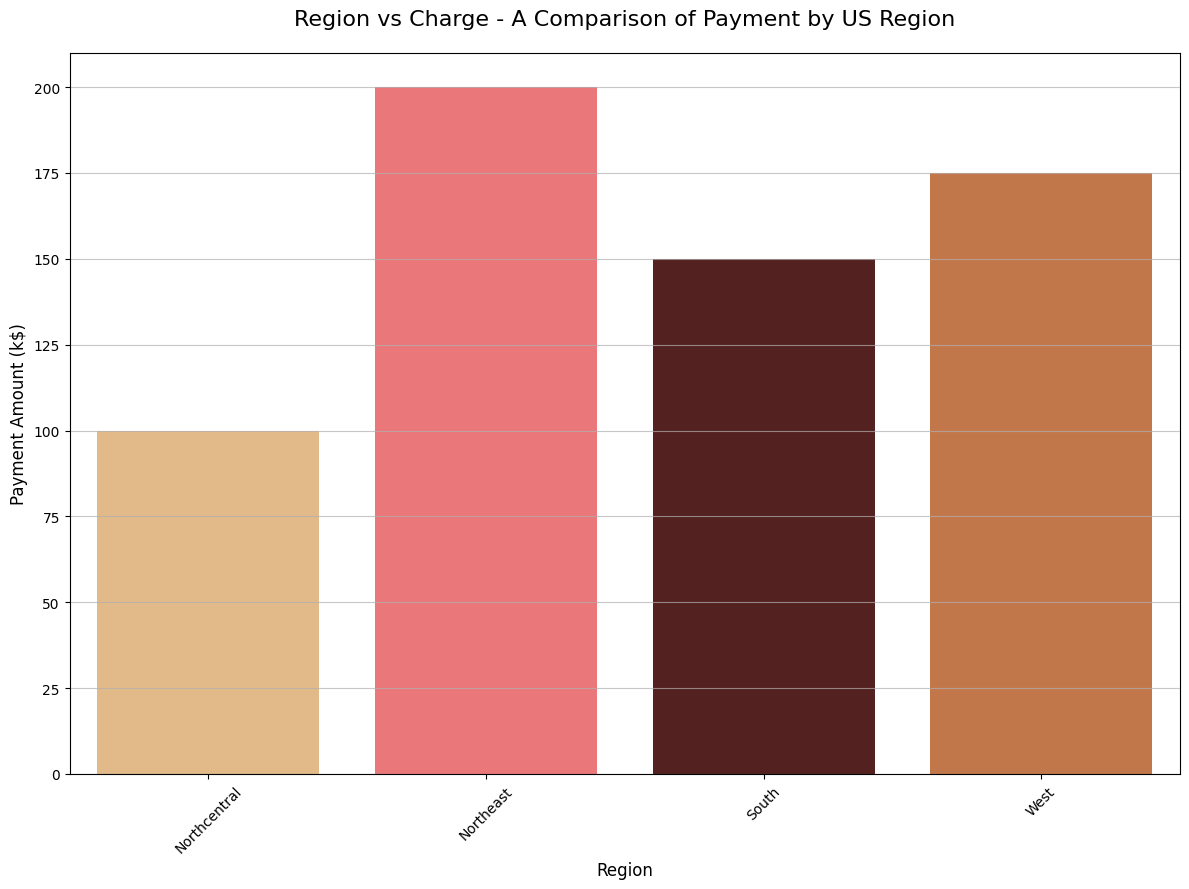

In [39]:
wes_palette = ["#F1BB7B", "#FD6467", "#5B1A18", "#D67236"]  # Replace with your chosen colors
new_region_names = ['Northcentral', 'Northeast', 'South', 'West']
plt.figure(figsize=(12, 9))
plt.title('Region vs Charge - A Comparison of Payment by US Region', fontsize=16, pad=20)
sns.barplot(x='region_mod', y='pay', data=df, palette=wes_palette)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Payment Amount (k$)', fontsize=12)
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(ticks=range(len(new_region_names)), labels=new_region_names, rotation=45)
plt.grid(axis='y', linestyle='-', alpha=0.7)

plt.grid(axis='y', linestyle='-', alpha=0.7)

plt.tight_layout()